# CNN From Scratch

## Imports

In [1]:
import numpy as np
from scipy import signal
import cv2
import matplotlib.pyplot as plt
import time

## Model 

#### Activations

In [52]:
class ReLU():
    def forward(self, input):
        self.input = input
        return np.maximum(0, input)
    
    def backward(self, output_grad, learning_rate):
        return np.multiply(output_grad, np.where(self.input <= 0, 0, 1))

class ELU():
    def __init__(self, alpha=1.0):
        self.alpha = alpha
    
    def forward(self, input):
        self.input = input
        return np.where(input > 0, input, self.alpha * (np.exp(input) - 1))
    
    def backward(self, output_grad, learning_rate):
        return np.multiply(output_grad, np.where(self.input > 0, 1, self.alpha * np.exp(self.input)))
    
class Softmax():
    def forward(self, input):
        # Subtract the maximum value from each row to avoid numerical instability
        input_max = np.max(input, axis=1, keepdims=True)
        input -= input_max

        tmp = np.exp(input)
        self.output = tmp / np.sum(tmp, axis=1, keepdims=True)
        return self.output
    
    def backward(self, output_gradient, learning_rate):
        eye = np.repeat(np.eye(output_gradient.shape[1]), output_gradient.shape[0], axis=0)
        input_grad = (self.output[:, :, None] * (eye - self.output[:, None, :]))
        
        return (output_gradient[:, None, :] @ input_grad).reshape(output_gradient.shape)

### Loss

In [38]:
def categorical_cross_entropy(y_true, y_pred):    
    # Clip predicted values to avoid log(0) errors
    epsilon = 1e-15
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    
    # Compute cross-entropy loss
    loss = -np.sum(y_true * np.log(y_pred))
    
    # Average loss over samples
    loss /= y_true.shape[1]
    
    return loss

def categorical_cross_entropy_prime(y_true, y_pred):
    # Clip predicted values to avoid log(0) errors
    epsilon = 1e-15
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    
    # Compute gradient of cross-entropy loss
    gradient = -y_true / y_pred
    
    return gradient

### Convolutional Layer

In [39]:
class ConvolutionalLayer():
    def __init__(self, input_shape:tuple, output_depth:int, kernel_size, padding=0, stride=1, bias:bool=True):
        self.input_depth, input_height, input_width = input_shape
        self.output_depth = output_depth
        self.kernel_size = kernel_size
        self.padding = padding
        self.stride = stride
        self.bias = bias

        if isinstance(kernel_size, int):
            self.kernel_size = (kernel_size, kernel_size)
        if isinstance(padding, int):
            self.padding = (padding, padding)
        if isinstance(stride, int):
            self.stride = (stride, stride)

        self.kernels_shape = (output_depth, self.input_depth, self.kernel_size[0], self.kernel_size[1])
        self.output_shape = (output_depth, int((input_height - self.kernel_size[0] + 2*self.padding[0] + self.stride[0]) / self.stride[0]), int((input_width - self.kernel_size[1] + 2*self.padding[1] + self.stride[0]) / self.stride[0]))
        self.dilated_gradient_shape = (output_depth, (input_height - self.kernel_size[0] + 2*self.padding[0] + 1), (input_width - self.kernel_size[1] + 2*self.padding[1] + 1))

        # Initialise weights and biases
        self.weights = np.random.randn(output_depth, self.input_depth, self.kernel_size[0], self.kernel_size[1]) * np.sqrt(2 / (self.input_depth * self.kernel_size[0] * self.kernel_size[1]))
        self.biases = np.zeros(self.output_depth)

    def forward(self, input):     
        # Padding
        input = np.pad(input, ((0, 0), (self.padding[0], self.padding[0]), (self.padding[1], self.padding[1])))
        self.input = input

        # Calculate output
        self.output = np.zeros(self.output_shape) + self.biases[:, np.newaxis, np.newaxis]
        for i in range(self.output_depth):
            for j in range(self.input_depth):
                # Cross correlation
                self.output[i] += signal.correlate2d(input[j], self.weights[i, j], "valid")[::self.stride[0], ::self.stride[1]]
        return self.output
    
    def backward(self, output_gradient, learning_rate):
        kernels_gradient = np.zeros(self.kernels_shape)
        input_gradient = np.zeros(self.input.shape)

        # Initialise dilated output gradient matrix
        dilated_output_gradient = np.zeros(self.dilated_gradient_shape)

        for i in range(self.output_depth):
            
            # Make the dilated output gradient
            for index_x, row in enumerate(output_gradient[i]):
                for index_y, gradient in enumerate(row):
                    dilated_output_gradient[i, index_x * (self.stride[0]), index_y * (self.stride[1])] = gradient

            # Calculate the gradients
            for j in range(self.input_depth):
                kernels_gradient[i, j] = signal.correlate2d(self.input[j], dilated_output_gradient[i], "valid")[::self.stride[0], ::self.stride[1]]
                input_gradient[j] += signal.convolve2d(dilated_output_gradient[i], self.weights[i, j], "full")

        # Update the weights
        self.weights -= learning_rate * kernels_gradient

        # Update the biases if needed
        if self.bias:
            self.biases -= learning_rate * np.sum(output_gradient, axis=(1, 2))

        # Crop the padding gradients
        if self.padding[0] != 0:
            input_gradient = input_gradient[:, self.padding[0]:-self.padding[0], :]
        if self.padding[1] != 0:
            input_gradient = input_gradient[:, :, self.padding[1]:-self.padding[1]]

        return input_gradient

### Pooling Layer

In [193]:
class MaxPooling():
    def __init__(self, input_shape, kernel_size, padding, stride):
        self.input_depth, input_height, input_width = input_shape
        self.output_depth = self.input_depth
        self.kernel_size = kernel_size
        self.padding = padding
        self.stride = stride

        if isinstance(kernel_size, int):
            self.kernel_size = (kernel_size, kernel_size)
        if isinstance(padding, int):
            self.padding = (padding, padding)
        if isinstance(stride, int):
            self.stride = (stride, stride)

        self.output_shape = (self.output_depth, int((input_height - self.kernel_size[0] + 2*self.padding[0] + self.stride[0]) / self.stride[0]), int((input_width - self.kernel_size[1] + 2*self.padding[1] + self.stride[0]) / self.stride[0]))

    def forward(self, input):      
        # Padding
        input = np.pad(input, ((0, 0), (self.padding[0], self.padding[0]), (self.padding[1], self.padding[1])), constant_values=-np.inf)
        self.input = input

        # Calculate output
        self.output = np.zeros(self.output_shape)
        for i in range(self.output_depth):
            for x in range(self.output_shape[1]):
                for y in range(self.output_shape[2]):
                    self.output[i, x, y] = np.max(input[i, x*self.stride[0]:x*self.stride[0]+self.kernel_size[0], y*self.stride[1]:y*self.stride[1]+self.kernel_size[1]])

        return self.output
    
    def backward(self, output_gradient, learning_rate):
        input_gradient = np.zeros(self.input.shape)
        
        for i in range(self.output_depth):
            for x in range(self.output_shape[1]):
                for y in range(self.output_shape[2]):
                    window = self.input[i, x*self.stride[0]:x*self.stride[0]+self.kernel_size[0], y*self.stride[1]:y*self.stride[1]+self.kernel_size[1]]
                    max_value = np.max(window)
                    input_gradient[i, x*self.stride[0]:x*self.stride[0]+self.kernel_size[0], y*self.stride[1]:y*self.stride[1]+self.kernel_size[1]] += (window == max_value) * output_gradient[i, x, y]
        
        # Crop the padding gradients
        if self.padding[0] != 0:
            input_gradient = input_gradient[:, self.padding[0]:-self.padding[0], :]
        if self.padding[1] != 0:
            input_gradient = input_gradient[:, :, self.padding[1]:-self.padding[1]]

        return input_gradient

### Flatten (Reshape) Layer

In [41]:
class Reshape():
    def __init__(self, input_shape, output_shape):
        self.input_shape = input_shape
        self.output_shape = output_shape

    def forward(self, input):
        return np.reshape(input, self.output_shape)

    def backward(self, output_gradient, learning_rate):
        return np.reshape(output_gradient, self.input_shape)

### Fully Connected Layer

In [42]:
class Dense():
    def __init__(self, input_size, output_size, bias:bool=True):
        self.weights = np.random.randn(input_size, output_size) * np.sqrt(2 / np.sum(input_size))
        self.bias = np.zeros(output_size) if bias else None

    def forward(self, input):
        self.input = input
        output = np.dot(input, self.weights)
        if self.bias is not None:
            output += self.bias
        return output

    def backward(self, output_gradient, learning_rate):
        weights_gradient = np.dot(output_gradient.T, self.input).T
        input_gradient = np.dot(self.weights, output_gradient.T).T

        self.weights -= learning_rate * weights_gradient

        if self.bias is not None:
            self.bias -= learning_rate * output_gradient.sum(axis=1)

        return input_gradient

## Instance Norm

In [72]:
class InstanceNorm:
    def __init__(self, num_features, eps=1e-5, affine=True):
        self.num_features = num_features
        self.eps = eps
        self.affine = affine
        
        if self.affine:
            self.gamma = np.ones((num_features, 1))
            self.beta = np.zeros((num_features, 1))
        else:
            self.gamma = None
            self.beta = None
        
        self.mean = None
        self.std = None
        self.x_flat = None

    def forward(self, x):
        self.input = x

        # Reshape the input tensor to compute mean and standard deviation along the feature dimension
        self.x_flat = x.reshape(self.num_features, -1)
        
        # Compute the mean and standard deviation along the feature dimension
        self.mean = np.mean(self.x_flat, axis=-1, keepdims=True)
        self.std = np.std(self.x_flat, axis=-1, keepdims=True)
        
        # Normalize the input tensor
        self.y_flat = (self.x_flat - self.mean) / (self.std + self.eps)
        
        # Apply the learnable scale and shift parameters if affine is True
        if self.affine:
            self.y_flat = self.gamma * self.y_flat + self.beta
        
        # Reshape the normalized output tensor to the original shape
        self.y = self.y_flat.reshape(x.shape)
        
        return self.y

    def backward(self, output_gradient, learning_rate):
        # Reshape the output gradient tensor
        dy_flat = output_gradient.reshape(self.num_features, -1)

        n = dy_flat.shape[-1]
        self.mean = self.mean[:, np.newaxis]
        self.std = self.std[:, np.newaxis]
        
        # Compute the gradients of the scale and shift parameters
        if self.affine:
            dgamma = np.array([np.dot(self.y_flat[i], dy_flat[i]) for i in range(len(self.y_flat))])
            dbeta = np.sum(dy_flat, axis=-1)
        else:
            dgamma = None
            dbeta = None

        # REDACT
        delta = np.eye(n)[None, :, :]
        delta = np.broadcast_to(delta, (self.num_features, n, n)) 

        term1 = (delta - 1 / n) / (self.std + self.eps)
        term2 = ((self.input - self.mean) / (n * self.std)).reshape(self.num_features, -1)[:, :, np.newaxis]
        term3 = ((self.input - self.mean) / ((self.std + self.eps)**2)).reshape(self.num_features, -1)[:, np.newaxis, :]

        dy_dx = term1 - term2 * term3

        dx_flat = np.array([np.dot(dy_dx[i], dy_flat[i]) for i in range(len(dy_dx))])

        if self.affine:
            dx_flat *= self.gamma
        
        # Reshape the input gradient tensor to the original shape
        dx = dx_flat.reshape(output_gradient.shape)

        # Update the parameters
        if self.affine:
            self.gamma -= learning_rate * dgamma[:, np.newaxis]
            self.beta -= learning_rate * dbeta[:, np.newaxis]
        
        return dx

In [68]:
inl = InstanceNorm(3)
x = np.random.randn(3, 4, 4)

inl.forward(x)

print(inl.backward(np.random.randn(3, 4, 4), 0.01))

(3, 16) (3, 16)
(3,)
(3,)
[[[-0.19121248 -0.63642721 -0.02808008 -0.24730336]
  [ 0.12550264  0.39071707  1.00188178  0.37752269]
  [-1.29329319  0.61715677  0.39802709 -0.62608009]
  [ 1.60753829 -0.14922    -0.37510045 -0.97162947]]

 [[ 0.32426159  0.35995621  0.52678364  0.15117549]
  [-1.77912334  0.39217036 -0.30745169  0.29807433]
  [ 0.79376865 -0.98153674 -0.85702014 -0.36037813]
  [-0.66821391 -0.70711539  1.32441688  1.49023219]]

 [[-1.90449552  0.22258805  0.30417717 -0.63640249]
  [ 0.76751165 -0.55452672  0.01851972  0.47835225]
  [-0.91067485  1.8473152   0.98325138 -0.57933185]
  [-0.88638754  1.35457139 -1.68512485  1.18065704]]]


## Train and predict functions

In [44]:
# Make better

def predict(network, input):
    output = input
    for layer in network:
        output = layer.forward(output)
    return output

def train(network, loss, loss_prime, x_train, y_train, x_test, y_test, epochs = 1000, learning_rate = 0.01, lr_decay = 0.99, batch_size = 32, verbose = True, test_epochs=10):
    errors = []
    test_scores = []
    for e in range(epochs):
        error = 0
        indices = np.random.permutation(len(x_train))[:batch_size]            
        for x, y in zip(x_train[indices], y_train[indices]):
            # forward
            output = predict(network, x)

            # error
            error += loss(y, output)

            # backward
            grad = loss_prime(y, output)
            for layer in reversed(network):
                grad = layer.backward(grad, learning_rate)

        error /= batch_size
        if verbose:
            print(f"{e + 1}/{epochs}, error={error}, lr = {learning_rate}")

        if e % test_epochs == 0:
            correct = 0
            indices = np.random.permutation(len(x_test))[:100]      
            for x, y in zip(x_test[indices], y_test[indices]):
                output = predict(network, x)
                correct += np.argmax(output) == np.argmax(y)

            test_scores.append(correct / len(x_test))

        learning_rate *= lr_decay

        errors.append(error)
    
    return errors, test_scores

## Data

#### Load MNIST digit dataset

In [45]:
from keras.datasets import mnist
from keras.utils import to_categorical

# Load MNIST data
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Normalize pixel values to the range [0, 1]
train_images = train_images.astype('float32') / 255
test_images = test_images.astype('float32') / 255

# Reshape the images data
train_images = np.expand_dims(train_images, axis=1)
test_images = np.expand_dims(test_images, axis=1)

# One-hot encode the labels
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

# Reshape the labels
train_labels = train_labels.reshape(-1, 1, 10)
test_labels = test_labels.reshape(-1, 1, 10)

#### Generating new images

In [46]:
def generate_new_images(images, labels, num_new_images):
    new_images = []
    new_labels = []
    
    for _ in range(num_new_images):
        # Select a random image from the input images
        index = np.random.randint(0, len(images) - 1)
        image = images[index][0]
        label = labels[index]
        
        # Random rotation angle
        angle = np.random.uniform(-10, 10)
        
        # Random zoom factor
        zoom_factor = np.random.uniform(0.9, 1.1)
        
        # Rotate and zoom the image
        rotated = rotate_image(image, angle)
        zoomed = zoom_image(rotated, zoom_factor)
        
        new_images.append(zoomed.reshape(1, 28, 28))
        new_labels.append(label)
        
    return np.array(new_images), np.array(new_labels)

def rotate_image(image, angle):
    height, width = image.shape
    center = (width // 2, height // 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, rotation_matrix, (width, height), flags=cv2.INTER_NEAREST)
    return rotated

def zoom_image(image, zoom_factor):
    height, width = image.shape
    new_height, new_width = int(height * zoom_factor), int(width * zoom_factor)
    zoomed = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_NEAREST)
    zoomed = cv2.resize(zoomed, (width, height), interpolation=cv2.INTER_NEAREST)
    return zoomed

In [47]:
generated_images, new_labels = generate_new_images(train_images, train_labels, 300000)
train_images = np.concatenate((train_images, generated_images))
train_labels = np.concatenate((train_labels, new_labels))

train_images.shape

(360000, 1, 28, 28)

## Defining the models

In [114]:
network_1 = [
    ConvolutionalLayer((1, 28, 28), 2, 3, padding=1),
    ELU(),
    MaxPooling((2, 28, 28), 2, 0, 2),
    Reshape((2, 14, 14) , (1, 2 * 14 * 14)),
    Dense(2 * 14 * 14, 10),
    Softmax()
]

network_2 = [
    ConvolutionalLayer((1, 28, 28), 2, 3, padding=1),
    ELU(),
    MaxPooling((2, 28, 28), 2, 0, 2),
    ConvolutionalLayer((2, 14, 14), 4, 3, padding=1),
    ELU(),
    MaxPooling((4, 14, 14), 2, 0, 2),
    Reshape((4, 7, 7) , (1, 4 * 7 * 7)),
    Dense(4 * 7 * 7, 64),
    ELU(),
    Dense(64, 10),
    Softmax()
]

network_3 = [
    ConvolutionalLayer((1, 28, 28), 8, 3, padding=1),
    InstanceNorm(8),
    ELU(),
    MaxPooling((8, 28, 28), 2, 0, 2),
    ConvolutionalLayer((8, 14, 14), 16, 3, padding=1),
    InstanceNorm(16),
    ELU(),
    MaxPooling((16, 14, 14), 2, 0, 2),
    Reshape((16, 7, 7) , (1, 16 * 7 * 7)),
    Dense(16 * 7 * 7, 512),
    ELU(),
    Dense(512, 128),
    ELU(),
    Dense(128, 10),
    Softmax()
]

network_4 = [
    ConvolutionalLayer((1, 28, 28), 8, 3, padding=1),
    InstanceNorm(8),
    ELU(),
    ConvolutionalLayer((8, 28, 28), 8, 3, padding=1),
    InstanceNorm(8),
    ELU(),
    ConvolutionalLayer((8, 28, 28), 8, 3, padding=1),
    InstanceNorm(8),
    ELU(),
    MaxPooling((8, 28, 28), 2, 0, 2),
    ConvolutionalLayer((8, 14, 14), 16, 3, padding=1),
    InstanceNorm(16),
    ELU(),
    ConvolutionalLayer((16, 14, 14), 32, 3, padding=1),
    InstanceNorm(32),
    ELU(),
    MaxPooling((32, 14, 14), 2, 0, 2),
    Reshape((32, 7, 7) , (1, 32 * 7 * 7)),
    Dense(32 * 7 * 7, 1024),
    ELU(),
    Dense(1024, 512),
    ELU(),
    Dense(512, 128),
    ELU(),
    Dense(128, 10),
    Softmax()
]

network_5 = [
    ConvolutionalLayer((1, 28, 28), 8, 3, padding=1),
    InstanceNorm(8),
    ELU(),
    ConvolutionalLayer((8, 28, 28), 8, 3, padding=1),
    InstanceNorm(8),
    ELU(),
    ConvolutionalLayer((8, 28, 28), 8, 3, padding=1),
    InstanceNorm(8),
    ELU(),
    MaxPooling2((8, 28, 28), 2, 0, 2),
    ConvolutionalLayer((8, 14, 14), 16, 3, padding=1),
    InstanceNorm(16),
    ELU(),
    ConvolutionalLayer((16, 14, 14), 32, 3, padding=1),
    InstanceNorm(32),
    ELU(),
    MaxPooling2((32, 14, 14), 2, 0, 2),
    Reshape((32, 7, 7) , (1, 32 * 7 * 7)),
    Dense(32 * 7 * 7, 1024),
    ELU(),
    Dense(1024, 512),
    ELU(),
    Dense(512, 128),
    ELU(),
    Dense(128, 10),
    Softmax()
]

#### Testing the forward and backward pass runtimes

In [125]:
def test_time(network, totals_only=False):
    output =train_images[0]
    tot = 0
    for layer in network:
        start = time.time()
        output = layer.forward(output)
        stop = time.time()

        if not totals_only:
            print(f"\tForward {layer.__class__.__name__} time: {stop - start}")
        tot += stop - start

    print(f"Forward total: {tot}")

    y = train_labels[0]
    grad = categorical_cross_entropy_prime(y, output)
    tot = 0
    for layer in reversed(network):
        start = time.time()
        grad = layer.backward(grad, 0)
        stop = time.time()

        if not totals_only:
            print(f"\tBackward {layer.__class__.__name__} time: {stop - start}")
        tot += stop - start

    print(f"Backward total: {tot}")

In [135]:
networks = [network_4, network_5]

for i, network in enumerate(networks):
    print(f"Network {i+1}:")
    test_time(network, totals_only=True)

Network 1:
Forward total: 0.027707815170288086
Backward total: 0.21729445457458496
Network 2:
Forward total: 0.04359102249145508
Backward total: 0.24150609970092773


## Training

In [58]:
networks = [network_1, network_2] #, network_3, network_4

In [59]:
# train
all_errors = []
all_test_scores = []
totals = []
for i, network in enumerate(networks):
    print(f"Network {i+1}:")
    errors, test_scores = train(
        network,
        categorical_cross_entropy,
        categorical_cross_entropy_prime,
        train_images,
        train_labels,
        test_images,
        test_labels,
        epochs=int(40 + 40 * (i) / (len(networks) - 1)),   # 35
        learning_rate=0.01,
        lr_decay=0.975,
        batch_size=128,   # 128
        test_epochs=5
    )

    all_errors.append(errors)
    all_test_scores.append(test_scores)

    # test
    correct = 0
    for x, y in zip(test_images, test_labels):
        output = predict(network, x)
        correct += np.argmax(output) == np.argmax(y)

    totals.append(correct / len(test_images))

    print(f"Network {i+1} test accuracy: {correct / len(test_images)}")

for i, network in enumerate(networks):
    print(f"Network {i+1}: {totals[i]}")

Network 1:
1/40, error=0.19788278275336915, lr = 0.01
2/40, error=0.12379017879922409, lr = 0.00975
3/40, error=0.09800749828688574, lr = 0.009506249999999999
4/40, error=0.07672266510084658, lr = 0.009268593749999998
5/40, error=0.0825670425973118, lr = 0.009036878906249999
6/40, error=0.0833144058691778, lr = 0.00881095693359375
7/40, error=0.09027746191471529, lr = 0.008590683010253905
8/40, error=0.06951139413694667, lr = 0.008375915934997558
9/40, error=0.060665379738033605, lr = 0.00816651803662262
10/40, error=0.0675245335449476, lr = 0.007962355085707053
11/40, error=0.07300158489746814, lr = 0.007763296208564377
12/40, error=0.059194922418656266, lr = 0.007569213803350267
13/40, error=0.05713727213897058, lr = 0.00737998345826651
14/40, error=0.06422356876835823, lr = 0.007195483871809847
15/40, error=0.052852189124348345, lr = 0.007015596775014601
16/40, error=0.054802166155272954, lr = 0.006840206855639235
17/40, error=0.05109813418349524, lr = 0.006669201684248254
18/40, er

KeyboardInterrupt: 

In [159]:
totals

[0.852, 0.9073, 0.9618, 0.9647]

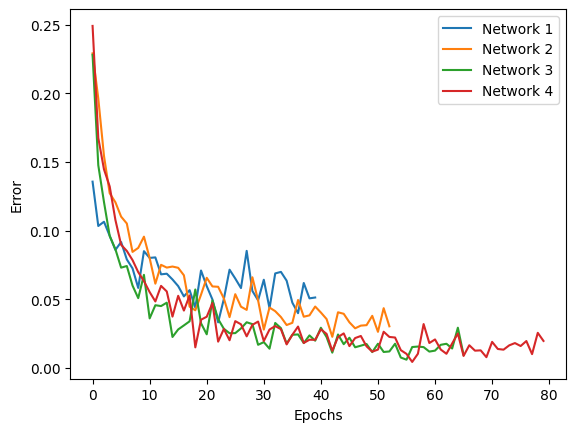

In [160]:
import matplotlib.pyplot as plt

for i, errors in enumerate(all_errors):
    plt.plot(errors, label=f"Network {i+1}")

plt.xlabel("Epochs")
plt.ylabel("Error")
plt.legend()

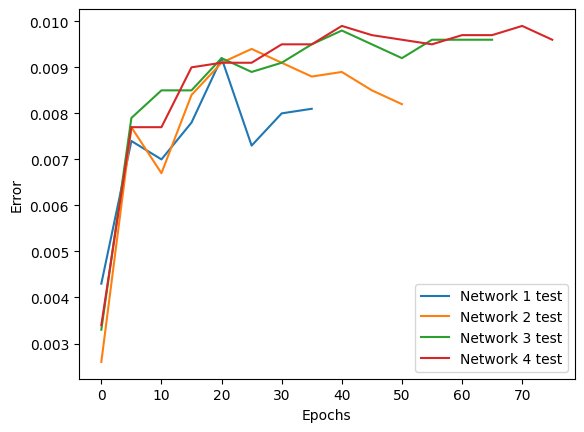

In [161]:
for i, test_scores in enumerate(all_test_scores):
    plt.plot(np.arange(0, len(test_scores) * 5, 5), test_scores, label=f"Network {i+1} test")

plt.xlabel("Epochs")
plt.ylabel("Error")
plt.legend()

## Adversarial Attack - FGSM

In [162]:
breakdowns = [[], [], [], []]
no_breakdowns = [0, 0, 0, 0]

for i in range(100):
    digit_id = i
    digit = test_images[digit_id]
    label = test_labels[digit_id]
    for j, newtwork in enumerate(networks):
        output = predict(newtwork, digit)

        output_gradient = categorical_cross_entropy_prime(label, output)
        for layer in reversed(network):
            output_gradient = layer.backward(output_gradient, 0)

        perturbations = np.sign(output_gradient) * 0.5 + 0.5

        epsilons = [0, 0.05, 0.1, 0.3, 0.5]

        for k, eps in enumerate(epsilons):
            adv_x = digit + eps * perturbations
            adv_x = (adv_x - np.min(adv_x)) / (np.max(adv_x) - np.min(adv_x))
            
            preds = predict(network, np.reshape(adv_x, (1, 28, 28)))

            if np.argmax(preds) != np.argmax(label):
                breakdowns[j].append(k)
                break

            if k == len(epsilons) - 1:
                no_breakdowns[j] += 1

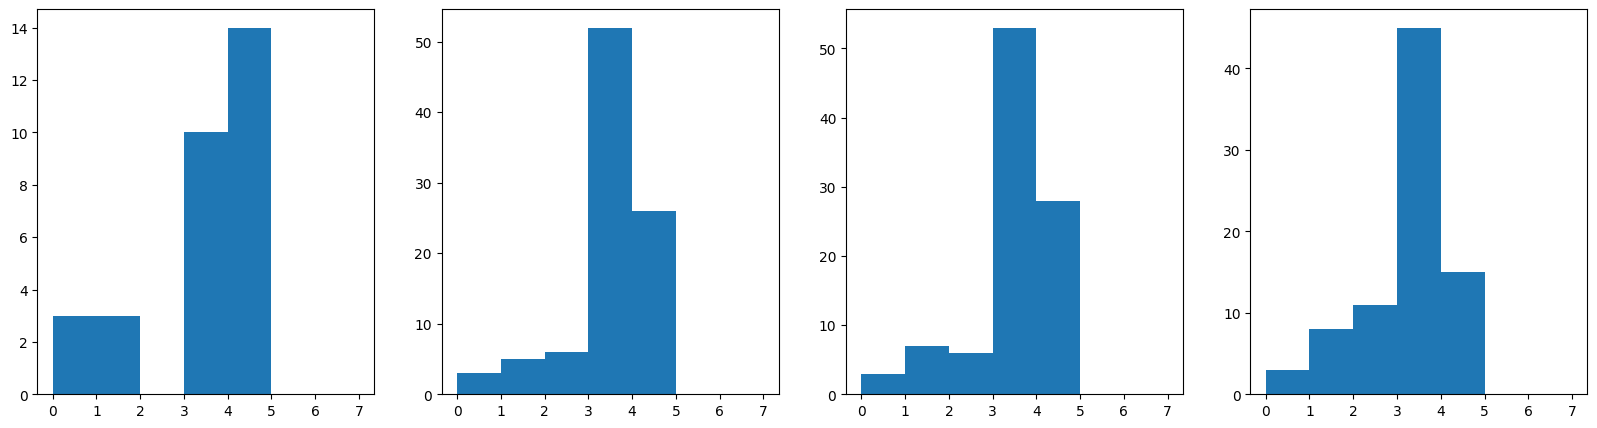

In [163]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

for i in range(4):
    ax[i].hist(breakdowns[i], bins=7, range=(0, 7))

In [31]:
print(no_breakdowns)

[83, 10, 3, 22]


In [35]:
print([len(i) for i in breakdowns])

[17, 90, 97, 78]
